## Import libraries

In [40]:
import os
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
from collections import defaultdict



In [41]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

Specify input and output folders here, they will be created if they don't exit

In [42]:
INPUT_FOLDER = "input_imgs"
OUTPUT_FOLDER = "lowpoly"

os.makedirs(INPUT_FOLDER, exist_ok=True)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

## Helper functions

### Reading and preprocessing
We start with reading in the image. For the most part, we only need to deal with a 2D image, so grayscaling needs to be applied to the image. Since, humand vision is more sensitive to luminance rather than chromatic differences(RGB), we will use the relative luminance (Rec. 709)[<sup>1</sup>](https://en.wikipedia.org/wiki/Luma_(video)#Luma_versus_relative_luminance) defined as

$Y = 0.2126R + 0.7152G + 0.0722B$

>Note that, by default for the grayscaling used by OpenCV or PIL, luma (CCIR 601) is calculated as
>$Y = 0.299R + 0.587G + 0.114B$

`PIL` does have a grayscaling mode based on the Rec. 709, however we cannot use that here since the output is still an image(array of `ints`) which adversely affects the points sampling we use later on

Next we take this grayscale and sharpen it, i.e, highlight the  important details. This can be achieved by making use of Gaussian filters. We first create a low blur image, where overall theme of the image is maintained and the finer details are ignored()i.e, blurred out. Next we create high blur image and take the difference of these two, and normalize it.

Again `PIL` also has a Gaussian blur feature, but same as before - it only returns `int` and so not very helpful for our application.


In [62]:
def read_process_input(filename):
	global im_arr
	im = Image.open(os.path.join(INPUT_FOLDER, filename))
	im_arr = np.array(im)
	# plt.imshow(im)

	perceptual_weight = np.array([0.2126, 0.7152, 0.0722])
	grayscale = (im * perceptual_weight).sum(axis=-1)
	plt.figure()
	# plt.imshow(grayscale);

	x = gaussian_filter(grayscale, 2, mode="reflect")
	x2 = gaussian_filter(grayscale, 30, mode="reflect")
	# Take the difference, deweight negatives, normalise
	diff = (x - x2)
	diff[diff < 0] *= 0.1
	diff = np.sqrt(np.abs(diff) / diff.max())

	plt.title("Highlights")
	plt.imshow(diff)
	return diff, im_arr

	

### Point sampling
Next we need to sample some points using rejection sampling[<sup>explained beatifully here</sup>](https://cosmiccoding.com.au/tutorials/rejection_sampling), and will do this in such a way that a random point $(x,y)$ within $[w,h]$ is accepted based on the luminance value at that image point



In [44]:
def sample_im(ref, n=1000000):
	np.random.seed(0)
	h,w = ref.shape
	xs = np.random.randint(0, w, size=n)
	ys = np.random.randint(0, h, size=n)
	value = ref[ys,xs]
	accept = np.random.random(size=n) < value
	points = np.array([xs[accept], ys[accept]])
	return points.T, value[accept]

In [57]:
def get_samples(diff):
	samples, v = sample_im(diff)
	plt.figure()
	plt.scatter(samples[:,0], -samples[:,1], c=v, s=0.2, edgecolors="none", cmap="viridis")
	plt.title("Scatter plot of samples")

	return samples

### Assign colours to triangles

Once the triangle vertices are generated, we need to assign colours to the triangles by averagin the RGB colours of all the image points within each triangle

In [46]:
def get_colour_of_tri(tri, img):
	colours = defaultdict(lambda: [])
	h, w, _ = img.shape
	idcs = np.indices((w,h)).transpose(1,2,0).reshape(-1,2)
	index = tri.find_simplex(idcs).reshape(w,h)
	for i in range(0, w):
		for j in range(0,h):
			colours[index[i,j]].append(img[j,i,:])
	
	for index, array in colours.items():
		colours[int(index)] = np.array(array).mean(axis=0)
	return colours

### Widget functions
The below 2 functions encapsulates everything so that they can be presented as interactive widgets

In [63]:
def load_plot_inp(filename):
	print("Normalized and highlighted:")
	diff, im_arr = read_process_input(filename)

	# print("Scatter plot")
	samples = get_samples(diff)

	h,w,_ = im_arr.shape

	corners = np.array([(0,0), (0, h-1), (w-1, 0), (w-1, h-1)])
	points = np.concatenate((corners, samples))

	return points, im_arr, filename
	
	
	

In [64]:
def generate_art(N, im_arr, points):
	n = 5 + N + 2 * int(N**2)
	print("No. of vertices: ", n)

	tri = Delaunay(points[:n, :])
	colours = get_colour_of_tri(tri, im_arr)

	h,w, _ = im_arr.shape
	im_out = Image.new("RGB", (w,h))
	im_draw = ImageDraw.Draw(im_out)

	for key,c in colours.items():
		t = tri.points[tri.simplices[key]]
		color = tuple(c.astype(np.uint8))
		im_draw.polygon(t.flatten().tolist(),fill=color, outline=color)

	plt.imshow(im_out)
	# im_out.save(f'lowpoly/out_{n}.png')
	return(im_out)

## Playing around

In [65]:
w = interactive(load_plot_inp, filename=os.listdir(INPUT_FOLDER))

In [66]:
display(w)

interactive(children=(Dropdown(description='filename', options=('148709192_389763002821550_8674950514758180380…

Since the second widget depends on the outputs of the first, we need to run the folowing cells everytime the input in the first widget is changed

In [67]:
points, im_arr, inp_name = w.result

In [68]:
w2 = interactive(generate_art, N=widgets.IntSlider(min=1, max=100, step=1, value=45), im_arr=fixed(im_arr), points=fixed(points))

In [69]:
display(w2)

interactive(children=(IntSlider(value=45, description='N', min=1), Output()), _dom_classes=('widget-interact',…

Run the below cells to see the output in full resolution and/or to save the art output

In [54]:
out = w2.result

# out.show()

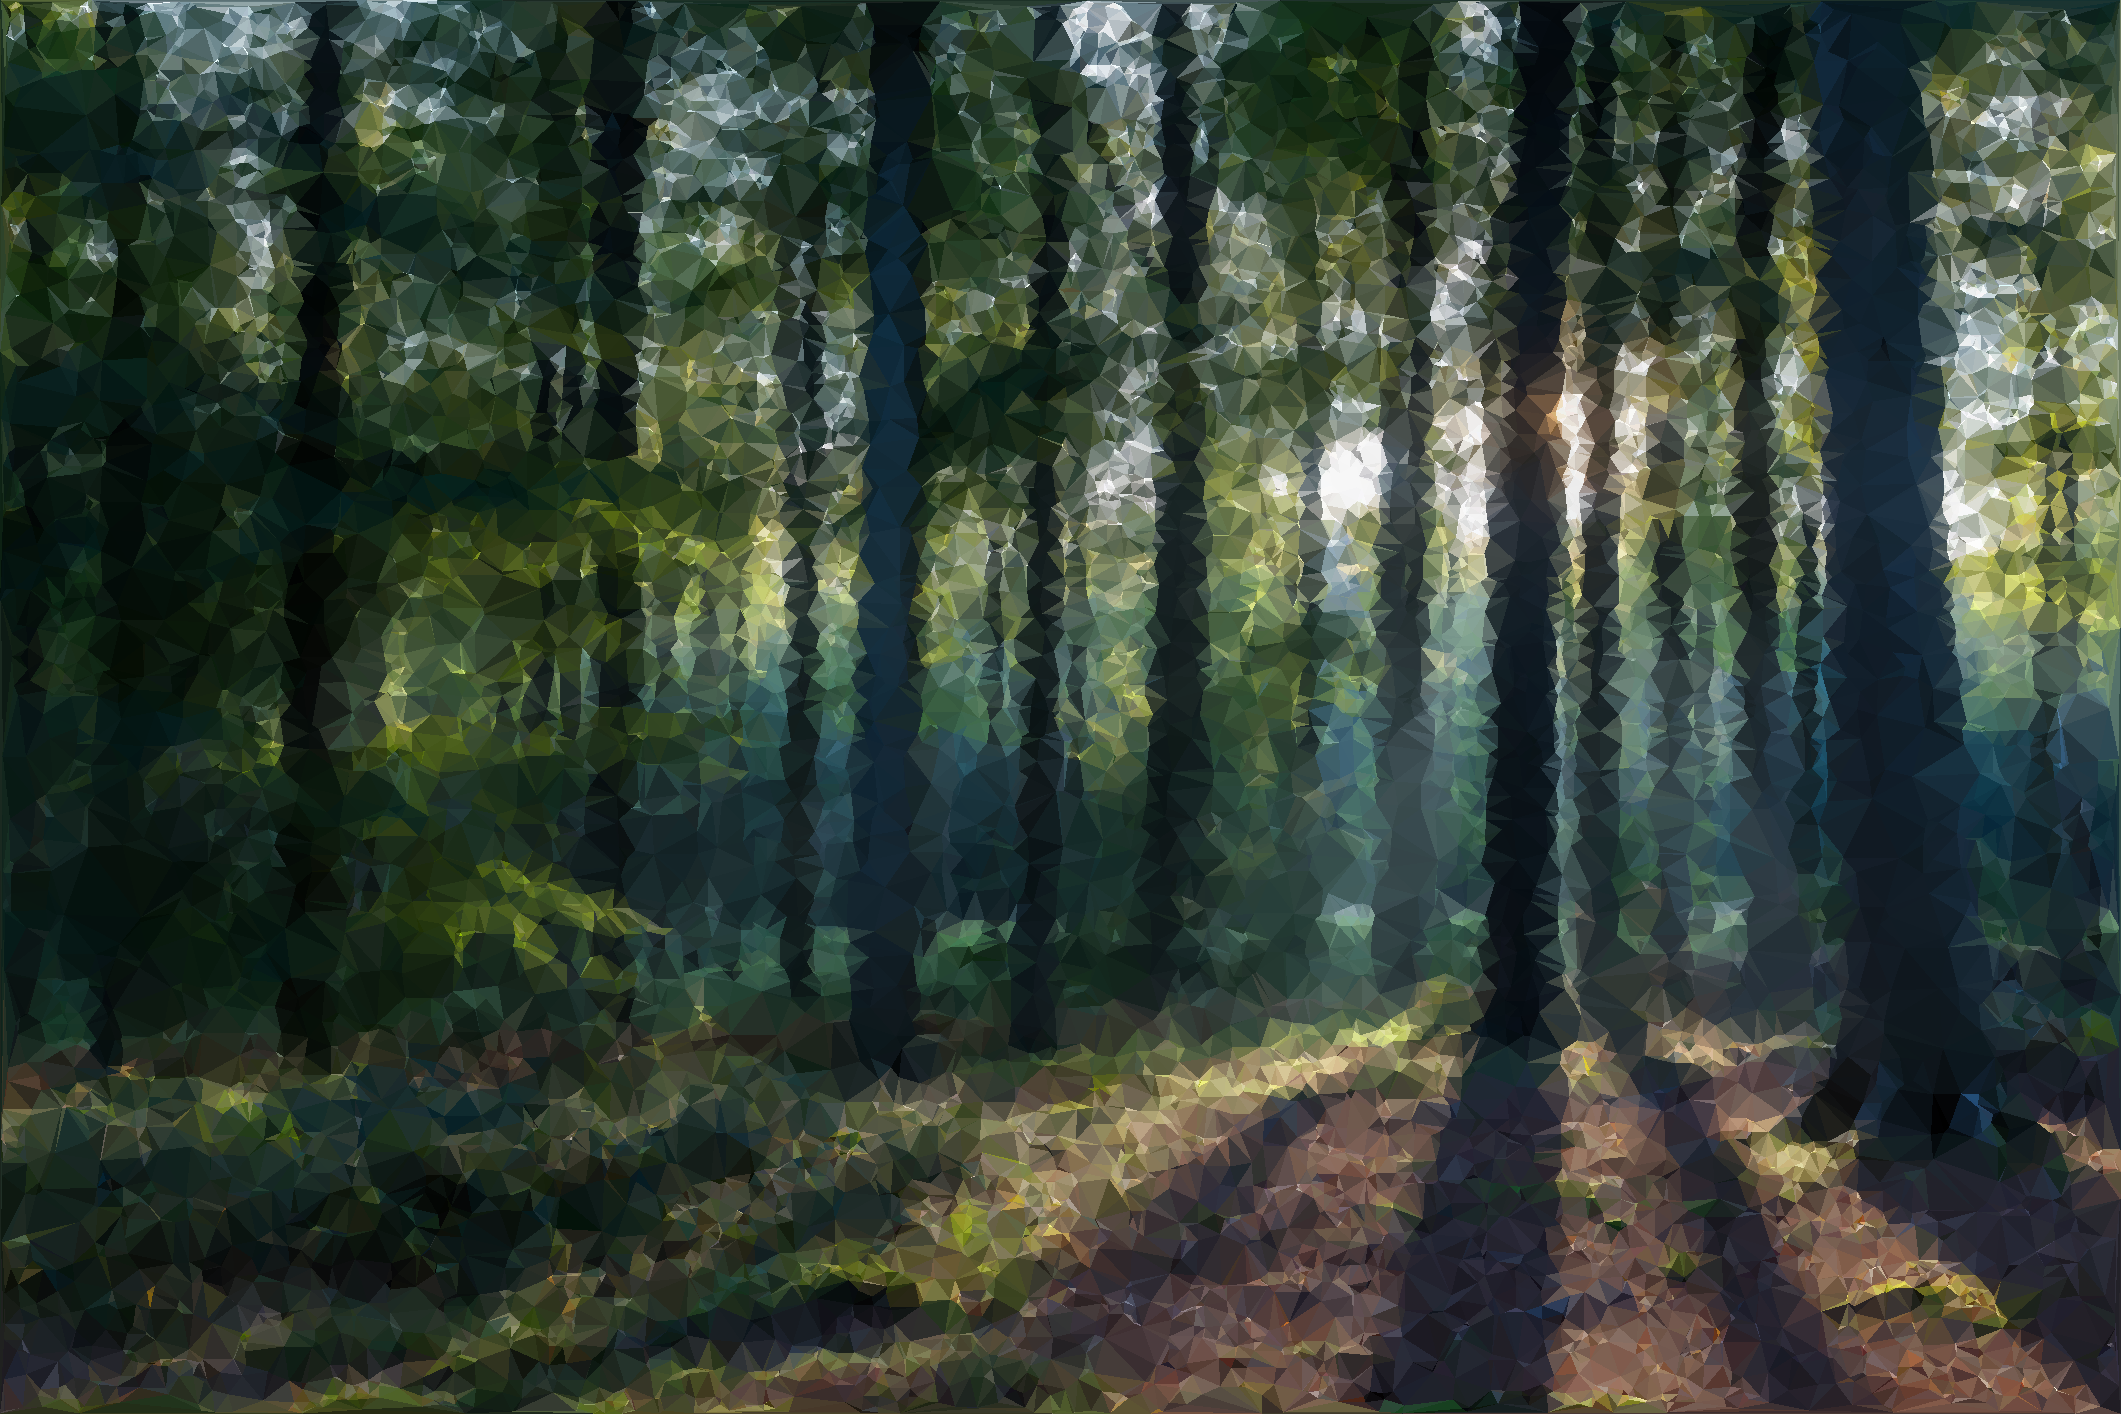

In [55]:
out

In [56]:
out.save(f"{OUTPUT_FOLDER}/{inp_name}")

## Save the poly art generation as GIF

In [38]:
def generate_art_gif(im_arr, points, out_name='polyOut'):
	im_outs = []
	# N = [1, 45, 60, 250, 500, 600, 1200, 1600, 2500, 3300, 4100]
	N = [1, 3, 6, 9, 12, 15, 20, 27, 33, 42, 55]
	for i in N:
		n = 5 + i + 2 * int(i**2)
		print(n)

		tri = Delaunay(points[:n, :])
		colours = get_colour_of_tri(tri, im_arr)

		h,w, _ = im_arr.shape
		im_out = Image.new("RGB", (w,h))
		# print(im_out.size)
		im_draw = ImageDraw.Draw(im_out)
		for key,c in colours.items():
			t = tri.points[tri.simplices[key]]
			# t[:, 0], t[:, 1] = t[:, 1], t[:, 0].copy()
			# print(t, len(t))
			color = tuple(c.astype(np.uint8))
			im_draw.polygon(t.flatten().tolist(),fill=color, outline=color)

		im_outs.append(im_out)

	im_outs[0].save(f'{OUTPUT_FOLDER}/{out_name}.gif', save_all=True, append_images=im_outs[1:], duration=200, loop=0, optimize=True)
	print(f"GIF saved to : {OUTPUT_FOLDER}/{out_name}.gif")
	# return(im_outs[0])

In [39]:
generate_art_gif(im_arr, points, out_name='spideyFall')

8
26
83
176
305
470
825
1490
2216
3575
6110
GIF saved to : lowpoly/spideyFall.gif
